# Project 4: Predicting outbreaks caused by West Nile Virus and using cost benefit analysis to help the City of Chicago.

Done by: Richelle-Joy Chia, Er Jie Yong, Meriky Lo 

Problem Statement: How can we help the City of Chicago Public Health Department accurately predict outbreaks and optimize measures to tackle financial burdens caused by WNV related diseases?

## Outline: 
- Part 1: Introduction, Exploratory Data Analysis, Data Cleaning, and Feature Engineering
- Part 2a: Preprocessing and Modeling 
- Part 2b: Preprocessing and Modeling using Weighted
- Part 3: Cost-benefit Analysis 

## Part 1: Introduction, Exploratory Data Analysis, Data Cleaning, and Feature Engineering

## Introduction

The West Nile Virus (WNV) can be spread to people by the bite of an infected mosquito. The peak period of such occurrence is during summer and fall, with a peak period for disease transmissions from July to September. Currently, WNV is the leading cause of mosquito-borne diseases in the United States (US). Based on statistics, 1 in 5 people experience mild symptoms while 1 in 150 experience severe symptoms. This is worrisome as there are currently no available vaccines.

Chicago is the most poulous city in the State of Illinois and the third most populous city in the US. As such, it is crucial to start taking effective actions to try to contain the massive spread among the public. The City of Chicago has been putting in place some intervention measures to contain the spread, one of which is to spray insecticides using aeroplanes and helicopters to treat large areas. 

For the scope of this project, we used 4 different datasets that were provided by the City of Chicago. Thereafter, we ran multiple models and picked the model with the best AUC.

### Problem Statement

Most often West Nile Virus causes mild, flu-like symptoms. However, in some cases, it can lead to life-threatening illnesses. Here at Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE), our goal is to build a model and make predictions that the city of Chicago can use when it decides where to spray pesticides. In order to do this, we engage with past data on the locations where West Nile virus were found with their weather conditions.

### Project Flow and Structure
Please refer to our Project Planning document to retrieve more details on how we worked on the project, a list of our feature engineering, and our modeling structure. 
- https://docs.google.com/spreadsheets/d/1yaMx3A26iPtJak6Bme8B-Hl1aj_j1mi1hd8g64Mq-6g/edit?usp=sharing


## Exploratory Data Analysis

This section explores the various datasets (e.g., train, test, weather, and spray) and fix errors, duplicates, and irrelevant values.

### Importing packages and datasets

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'. We supress the pandas warning on SettingWithCopyWarning 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
from datetime import datetime, timedelta
from sklearn.neighbors import DistanceMetric
from math import radians
import scipy

#to allow for progress tracking
from tqdm import tqdm
tqdm.pandas()

#we only do the following as we are using sklearn 0.23.2
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.graphics.tsaplots import plot_acf

In [2]:
df_train_org = pd.read_csv("./assets/train.csv")
df_test_org = pd.read_csv("./assets/test.csv")
df_spray_org = pd.read_csv("./assets/spray.csv")
df_weather_org = pd.read_csv("./assets/weather.csv")

In [3]:
# We do a copy of the original to retain the original data in case we need to reference to it again
df_train = df_train_org.copy()
df_test = df_test_org.copy()
df_spray = df_spray_org.copy()
df_weather = df_weather_org.copy()

### Train dataset

Over here, we examined the data types, fixed the data types, the first 5 rows of the dataset, and whether the data is balanced.

In [4]:
# Print out info of train dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [5]:
# Examine dataset
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [6]:
# Check if data is balance
df_train['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

- 95% of the traps were negative for WNV, suggesting that our dataset is imbalanced. We will account for this when we work on the modeling.

In [7]:
# Convert Date column to datetime format
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%Y-%m-%d')

In [8]:
# Add Week and Year columns
df_train['Week'] = (df_train['Date'].dt.strftime('%W')).astype(int)
df_train['Month'] = (df_train['Date'].dt.strftime('%m')).astype(int)
df_train['Year'] = (df_train['Date'].dt.strftime('%Y')).astype(int)

In this sub-section, we examined the number of mosquitos per year and per species and found that not all mosquitos species carry WNV. These are the species that carry WNV: Culex Pipiens/Restauns, Culex Pipiens, and Culex Restauns.

/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2912630470.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_mozzie = df_train.groupby(['Year','Species'], as_index=False).sum().reindex()


Text(0, 0.5, 'Number of mosquitos')

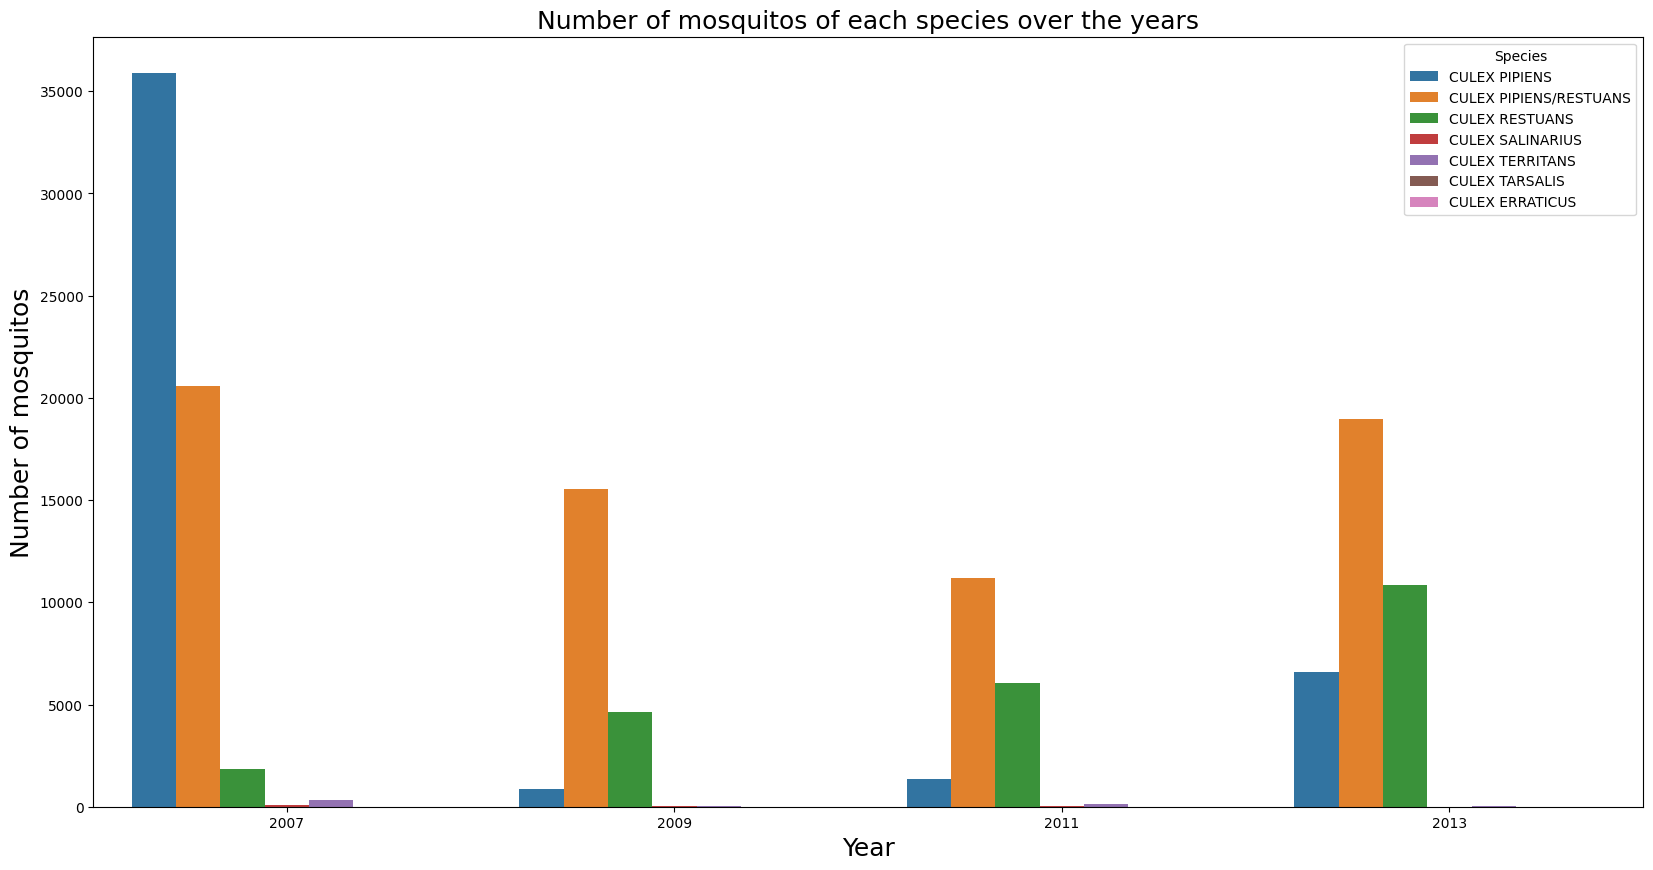

In [9]:
# Number of mosquitos per year and per species

year_mozzie = df_train.groupby(['Year','Species'], as_index=False).sum().reindex()

plt.figure(figsize=(20,10))
sns.barplot(x='Year',y='NumMosquitos',hue='Species',data= year_mozzie)
plt.title('Number of mosquitos of each species over the years',fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Number of mosquitos', fontsize=18)

Based on the analyses below, we can see that these are the only species who carry the virus - Culex Pipiens/Restuans, Culex Pipiens and Culex Restauans. 

In [10]:
# Sort out species with WNV
wnv_species = df_train.loc[df_train['WnvPresent'] == 1,['Species']]
wnv_species['Species'].value_counts()

CULEX PIPIENS/RESTUANS    262
CULEX PIPIENS             240
CULEX RESTUANS             49
Name: Species, dtype: int64

Text(0.5, 1.0, 'Mosquitoes Species with West Nile Virus')

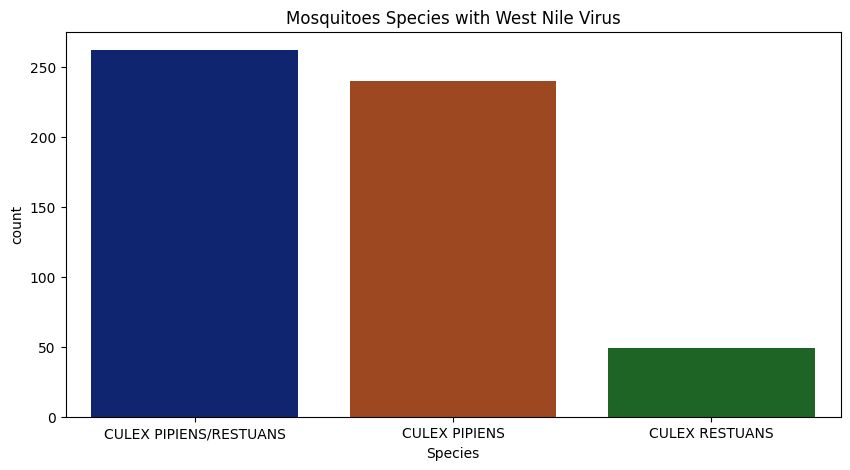

In [11]:
# plot to see the number of species with WNV 
plt.figure(figsize=(10,5))
sns.countplot(x = 'Species',data = wnv_species,palette='dark')
plt.title('Mosquitoes Species with West Nile Virus')

Since we were told that if there are more than 50 mosquitoes present, the data will be split up into 2 rows. As such, we combined such cases to be in the same row to prevent duplicates. 

In [12]:
# Checking for records that have WnVPresent and have num of mosquitos over 50 (note: if there are more than 50 mosquitos, it will be split into another record/row in the dataset).
wnv_present = df_train[df_train['WnvPresent'] == 1]
wnv_present[wnv_present['NumMosquitos'] == 50]

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Week,Month,Year
553,2007-07-18,"3800 East 115th Street, Chicago, IL 60617, USA",CULEX PIPIENS/RESTUANS,38,E 115TH ST,T215,"3800 E 115TH ST, Chicago, IL",41.686398,-87.531635,8,50,1,29,7,2007
603,2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,50,1,30,7,2007
611,2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,50,1,30,7,2007
618,2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,50,1,30,7,2007
660,2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.673408,-87.599862,5,50,1,30,7,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10031,2013-09-06,"2200 North Cannon Drive, Chicago, IL 60614, USA",CULEX PIPIENS,22,N CANNON DR,T054,"2200 N CANNON DR, Chicago, IL",41.921965,-87.632085,8,50,1,35,9,2013
10058,2013-09-06,"4500 North Campbell Avenue, Chicago, IL 60625,...",CULEX PIPIENS/RESTUANS,45,N CAMPBELL AVE,T220,"4500 N CAMPBELL AVE, Chicago, IL",41.963976,-87.691810,9,50,1,35,9,2013
10122,2013-09-06,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,50,1,35,9,2013
10124,2013-09-06,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,50,1,35,9,2013


In [13]:
# Merge rows that have more than 50 mosquitos 
df_train = df_train.groupby(['Date','Week', 'Month', 'Year','Species','Trap','Latitude',
                            'Longitude'])['NumMosquitos','WnvPresent'].sum().reset_index()

/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/3390888479.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_train = df_train.groupby(['Date','Week', 'Month', 'Year','Species','Trap','Latitude',


In [14]:
# See the number of unique mosquitos 
df_train['NumMosquitos'].unique()

array([   1,    2,    4,    3,    5,    7,    9,   10,    8,    6,   20,
         19,   25,   16,   28,   11,   12,   29,   18,   39,   51,   22,
         15,  143,   27,   14,   13,  189,   17,   21,   34,   26,   30,
         50,  100,   42,  102,   63,   76,   53,  418,   32, 2356,   55,
        502,  644,   83,  411,   23,   67,   72,   41,   24,   52,   89,
         88, 1543,   36,  477,  104,   82,   31,   46,   65,   69,  223,
         61,  378,  765,  219,   43,  164,  203,   70,   57,   33,  712,
        184,   35,  266,  362,  200,  113,  153,   54,  154,   44,   37,
         45,   56,   62,  110, 1310,  305, 1658,  137,  315,   80,  234,
        115,  118,   79,  138,  157,   90,   38,   49,   98,  108,   86,
        130,  146,  253,   74,   71, 2532,  821, 1000,  651,  174,   60,
        279,  121,  177,   85,  209, 1554,  217,  231, 1054,   40,  230,
         68,  106,  421, 2207,  290,  561,   48,  211,  399,  269,  123,
        127,   75, 1648,   47,  387,  914,  116,  9

In [15]:
# Check to see that the rows have been created and combined 
df_train.head()

,Date,Week,Month,Year,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,22,5,2007,CULEX PIPIENS,T096,41.731922,-87.677512,1,0
1,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
2,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0
3,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0
4,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0


In [16]:
# Based on preliminary analyses, we know that this particular date has more than 50 mosquitos. Hence, this step checks to see if the columns are accurate.  
df_train[df_train['Date'].dt.date== pd.to_datetime('2007-08-01')].sort_values('Trap').head()

/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/1173290901.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_train[df_train['Date'].dt.date== pd.to_datetime('2007-08-01')].sort_values('Trap').head()


,Date,Week,Month,Year,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
657,2007-08-01,31,8,2007,CULEX PIPIENS,T001,41.953705,-87.733974,1,0
747,2007-08-01,31,8,2007,CULEX PIPIENS/RESTUANS,T001,41.953705,-87.733974,3,0
658,2007-08-01,31,8,2007,CULEX PIPIENS,T002,41.954690,-87.800991,67,0
748,2007-08-01,31,8,2007,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,104,2
849,2007-08-01,31,8,2007,CULEX RESTUANS,T002,41.954690,-87.800991,8,0


In [17]:
# Re-label columns to 0 (absence of WNV) and 1 (presence of WNV) as the previous rows did a summation of the rows for WnvPresent
df_train['WnvPresent'] = df_train['WnvPresent'].apply(lambda x: 1 if x > 0 else 0)

In [18]:
# Check on the shape after merging the rows
df_train.shape

(8475, 10)

The next step would be to convert the species name to integer that would work better in our analyses.  

In [19]:
# Convert name of species to integer 

df_train['species_no'] = df_train['Species'].map({'CULEX PIPIENS/RESTUANS': 2,'CULEX PIPIENS': 2,'CULEX RESTUANS': 1})
df_train['species_no'].fillna(value=0,inplace=True)

# Occurrences in species type
df_train['species_no'].value_counts()

2.0    5776
1.0    2393
0.0     306
Name: species_no, dtype: int64

In [20]:
# Check dataframe
df_train.head()

,Date,Week,Month,Year,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,species_no
0,2007-05-29,22,5,2007,CULEX PIPIENS,T096,41.731922,-87.677512,1,0,2.0
1,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2.0
2,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,2.0
3,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0,2.0
4,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0,2.0


Then, we would like to look at the data spread of mosquitos across the years and months.

In [21]:
# Look at data across the years
df_train['Year'].value_counts()

2007    2775
2013    2012
2009    1915
2011    1773
Name: Year, dtype: int64

In [22]:
# Looking at data spread across the months
df_train['Month'].value_counts(normalize=True).sort_index()

5     0.009558
6     0.157758
7     0.247316
8     0.324484
9     0.229735
10    0.031150
Name: Month, dtype: float64

In the next step, we created a new variable called distance between stations, which will also be useful for merging. 

In [23]:
# Calculate distance between two points to create 'station' variable
station1 = (41.995, -87.933) #Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT
station2 = (41.786, -87.752) #Station 2: CHICAGO MIDWAY INTL ARPT
def get_station(lat, long):
    dist1 = geopy.distance.distance((lat, long), station1).km
    dist2 = geopy.distance.distance((lat, long), station2).km
    return 1 if dist1 < dist2 else 2

df_train['Station'] = [get_station(df_train.loc[i,'Latitude'],df_train.loc[i,'Longitude']) for i in df_train.index]

In [24]:
# Check df to see everything is in order
df_train.head()

,Date,Week,Month,Year,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,species_no,Station
0,2007-05-29,22,5,2007,CULEX PIPIENS,T096,41.731922,-87.677512,1,0,2.0,2
1,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2.0,1
2,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,2.0,1
3,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0,2.0,2
4,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0,2.0,2


### Now, we will be moving on to the test dataset

Same as the train dataset, we examined the data types, fixed the data types, and the first 5 rows of the dataset. 

In [25]:
# Print out info of test dataset 
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [26]:
# Examine dataset
df_test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [27]:
# Convert Date column to datetime format
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%Y-%m-%d')

# Add Week and Year columns
df_test['Week'] = (df_test['Date'].dt.strftime('%W')).astype(int)
df_test['Month'] = (df_test['Date'].dt.strftime('%m')).astype(int)
df_test['Year'] = (df_test['Date'].dt.strftime('%Y')).astype(int)

The next step would be to convert the species name to integer that would work better in our subsequent analyses.

In [28]:
# Convert name of species to integer 

df_test['species_no'] = df_test['Species'].map({'CULEX PIPIENS/RESTUANS': 2,'CULEX PIPIENS': 2,'CULEX RESTUANS': 1})
df_test['species_no'].fillna(value=0,inplace=True)

# Occurrences in species type
df_test['species_no'].value_counts()

0.0    71743
2.0    29880
1.0    14670
Name: species_no, dtype: int64

In [29]:
# Check to see if species were re-coded accurately
df_test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Week,Month,Year,species_no
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,23,6,2008,2.0
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,23,6,2008,1.0
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,23,6,2008,2.0
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,23,6,2008,0.0
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,23,6,2008,0.0


Here, we looked at the data spead across the years and months too.

In [30]:
# Look at data across the years
df_test['Year'].value_counts()

2010    36557
2008    30498
2012    27115
2014    22123
Name: Year, dtype: int64

In [31]:
# Looking at data spread across the months
df_test['Month'].value_counts(normalize=True).sort_index()

6     0.167491
7     0.306682
8     0.284755
9     0.220237
10    0.020835
Name: Month, dtype: float64

In [32]:
# Calculate distance between two points to create 'station' variable, which will also be useful for merging
station1 = (41.995, -87.933) #Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT
station2 = (41.786, -87.752) #Station 2: CHICAGO MIDWAY INTL ARPT
def get_station(lat, long):
    dist1 = geopy.distance.distance((lat, long), station1).km
    dist2 = geopy.distance.distance((lat, long), station2).km
    return 1 if dist1 < dist2 else 2

df_test['Station'] = [get_station(df_test.loc[i,'Latitude'],df_test.loc[i,'Longitude']) for i in df_test.index]

In [33]:
# Check df to see everything is in order
df_test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Week,Month,Year,species_no,Station
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,23,6,2008,2.0,1
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,23,6,2008,1.0,1
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,23,6,2008,2.0,1
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,23,6,2008,0.0,1
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,23,6,2008,0.0,1


### Next, we will examine the spray dataset

Here, we did the same as above where we examined the data types, fixed the data types, dropped duplicates, and looked at the first 5 rows of the dataset.

In [34]:
# Print out info of spray dataset 
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [35]:
# Examine dataset
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [36]:
# Convert Date column to datetime format
df_spray['Date'] = pd.to_datetime(df_spray['Date'], format='%Y-%m-%d')

# Add Week and Year columns
df_spray['Week'] = (df_spray['Date'].dt.strftime('%W')).astype(int)
df_spray['Month'] = (df_spray['Date'].dt.strftime('%m')).astype(int)
df_spray['Year'] = (df_spray['Date'].dt.strftime('%Y')).astype(int)

In [37]:
# Convert Time column to datetime format
# We leave the time as is with the default date as we want to be able to filter it using pandas
df_spray['Time'] = pd.to_datetime(df_spray['Time'], format='%I:%M:%S %p')

In [38]:
# Sorting out data and reindexing
df_spray = df_spray.groupby(['Date','Week', 'Month', 'Year','Time', 'Latitude',
                            'Longitude'], as_index=False).sum().reindex()

In [39]:
# Check if there are any missing values
df_spray.isnull().sum()

Date         0
Week         0
Month        0
Year         0
Time         0
Latitude     0
Longitude    0
dtype: int64

In [40]:
# Drop duplicates
df_spray.drop_duplicates(inplace=True)

Similarly, here is the spread of the data across the years and months.

In [41]:
# Look at data across the years
df_spray['Year'].value_counts()

2013    12626
2011     1084
Name: Year, dtype: int64

In [42]:
# Look at data across the months
df_spray['Month'].value_counts()

8    7988
7    3809
9    1913
Name: Month, dtype: int64

In [43]:
# Look at data across spray dates
df_spray['Date'].value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2011-09-07     989
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

In [44]:
# Visualizing spray data
df_spray['Date'].unique()

array(['2011-08-29T00:00:00.000000000', '2011-09-07T00:00:00.000000000',
       '2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [45]:
# Get spray dates
spray_dates = df_spray['Date'].unique()
spray_2011 = spray_dates[:2]
spray_2013 = spray_dates[2:]

In [46]:
df_train.head()

,Date,Week,Month,Year,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,species_no,Station
0,2007-05-29,22,5,2007,CULEX PIPIENS,T096,41.731922,-87.677512,1,0,2.0,2
1,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2.0,1
2,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,2.0,1
3,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0,2.0,2
4,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0,2.0,2


#### In this sub-section, we would like to see the number of mosquitoes, the number of WNV present, and whether or not the spray was effective in reducing the number of mosquitoes.
- The figures below show that the number of mosquitoes did not decrease much after the spray. One possibility could be because the spraying occurs only after the peak.

In [47]:
# Explore data from both years (2011 and 2013) 
wnv_2011 = df_train[df_train['Date'].dt.year==2011].groupby('Date')['WnvPresent'].sum()
wnv_2013 = df_train[df_train['Date'].dt.year==2013].groupby('Date')['WnvPresent'].sum()
mosquitos_2011 = df_train[df_train['Date'].dt.year==2011].groupby('Date')['NumMosquitos'].sum()
mosquitos_2013 = df_train[df_train['Date'].dt.year==2013].groupby('Date')['NumMosquitos'].sum()

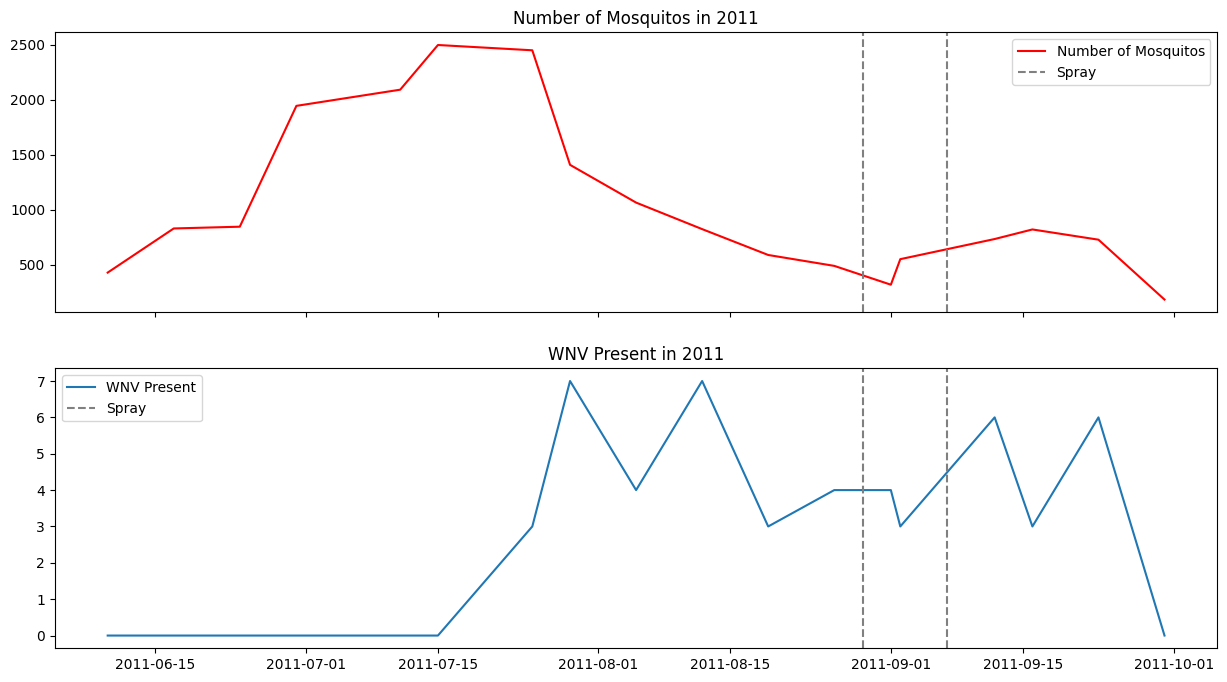

In [48]:
# Visualization to see the number of mosquitos across the years (2011 and 2013)
fig, axes = plt.subplots(nrows=2,sharex=True, figsize=(15,8))

axes[0].plot(mosquitos_2011.index,mosquitos_2011.values,color='red')
for spray_date in spray_2011:
    axes[0].axvline(x=spray_date, color='grey', ls='--')
axes[0].set_title('Number of Mosquitos in 2011')
axes[0].legend(['Number of Mosquitos','Spray']);

axes[1].plot(wnv_2011.index,wnv_2011.values)
for spray_date in spray_2011:
    axes[1].axvline(x=spray_date, color='grey', ls='--')
axes[1].set_title('WNV Present in 2011')
axes[1].legend(['WNV Present','Spray']);

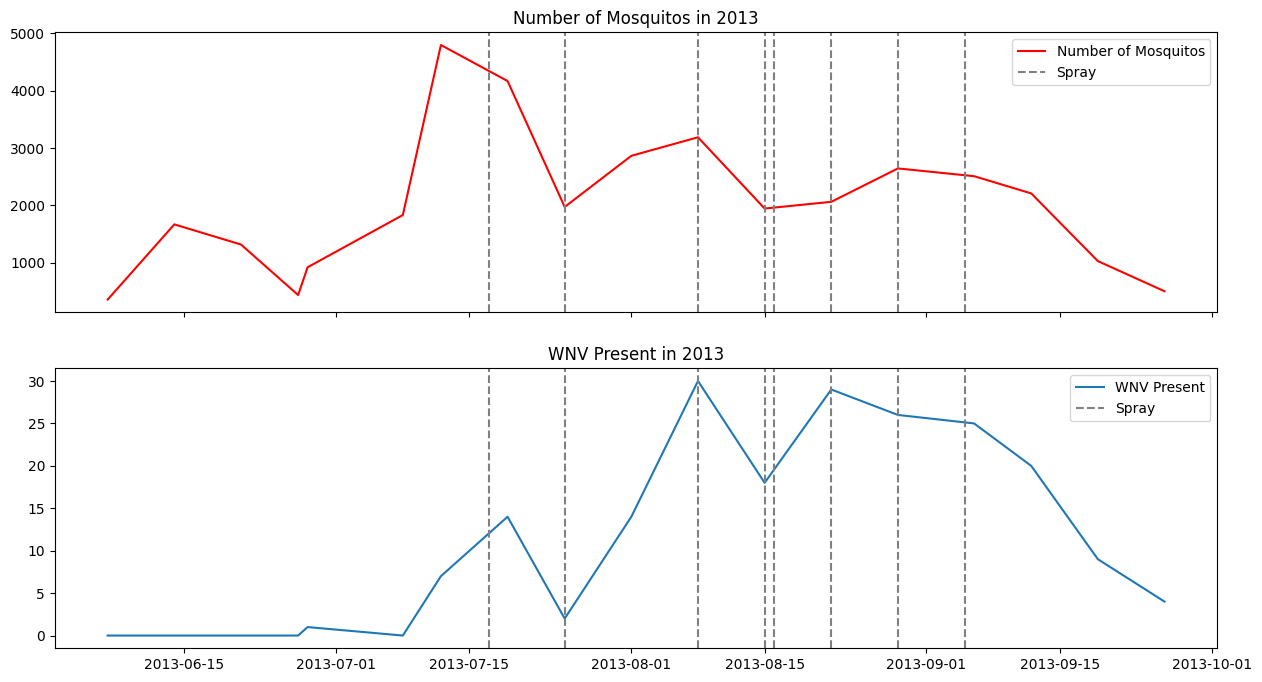

In [49]:
fig, axes = plt.subplots(nrows=2,sharex=True, figsize=(15,8))

axes[0].plot(mosquitos_2013.index,mosquitos_2013.values,color='red',label='Number of Mosquitos')
for spray_date in spray_2013:
    axes[0].axvline(x=spray_date, color='grey', ls='--')
axes[0].set_title('Number of Mosquitos in 2013');
axes[0].legend(['Number of Mosquitos','Spray'], loc=1);
# ax2.legend(loc=1)

axes[1].plot(wnv_2013.index,wnv_2013.values)
for spray_date in spray_2013:
    axes[1].axvline(x=spray_date, color='grey', ls='--')
axes[1].set_title('WNV Present in 2013');
axes[1].legend(['WNV Present','Spray']);

### Finally, we will examine the weather dataset

In this section, we did similar steps whereby we examined the data types and replaced values accordingly. 

- In sum, these 4 variables (e.g., depart, depth, water1, snowfall) were deleted as there were more than 50% of data missing.

In [50]:
# Print out info of test dataset 
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [51]:
# Examine dataset
df_weather

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,M,34,42,20,0,...,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,...,,0,M,0.0,0.00,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45,M,35,42,20,0,...,RA,M,M,M,T,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,...,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9


In [52]:
#
df_weather.replace('M', np.nan, inplace=True)
df_weather.replace('-', np.nan, inplace=True)

### Date

In [53]:
# Convert Date column to datetime format
df_weather['Date'] = pd.to_datetime(df_weather['Date'], format='%Y-%m-%d')

In [54]:
# Separate Year, Month, and Day for future analysis 
df_weather['Year'] = df_weather['Date'].dt.year
df_weather['Month'] = df_weather['Date'].dt.month
df_weather['Day'] = df_weather['Date'].dt.day

#### Below, we explored each of the variables in the weather dataset.

### Tavg

In [55]:
df_weather['Tdiff'] = (df_weather['Tmax'] + df_weather['Tmin'])/2

/Users/richelle-joychia/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='Tmax', ylabel='Tavg'>

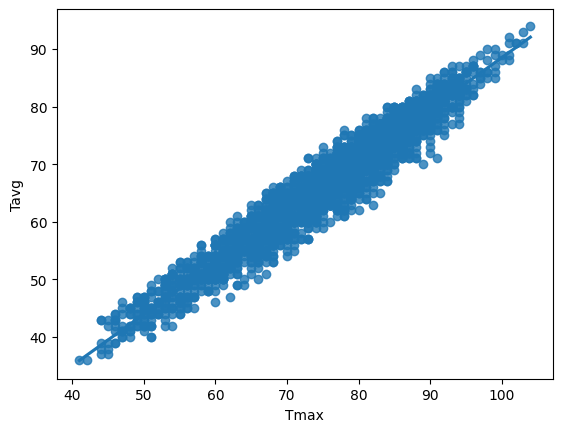

In [56]:
sns.regplot(df_weather['Tmax'][df_weather['Tavg'].notnull()].astype(int), df_weather['Tavg'][df_weather['Tavg'].notnull()].astype(int))

<AxesSubplot: xlabel='Tmin', ylabel='Tavg'>

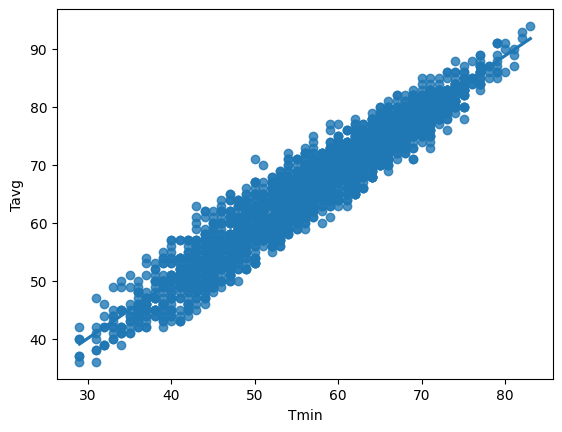

In [57]:
sns.regplot(df_weather['Tmin'][df_weather['Tavg'].notnull()].astype(int), df_weather['Tavg'][df_weather['Tavg'].notnull()].astype(int))

<AxesSubplot: xlabel='Tdiff', ylabel='Tavg'>

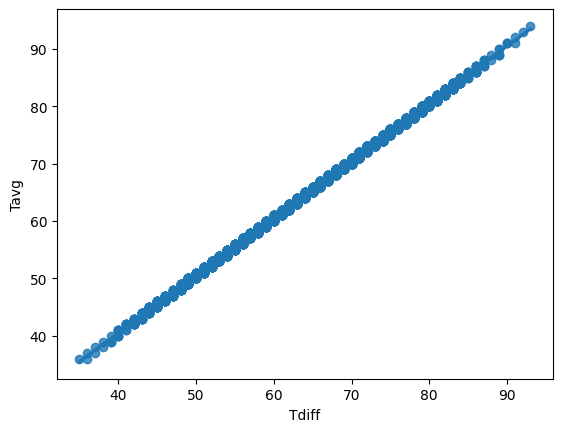

In [58]:
sns.regplot(df_weather['Tdiff'][df_weather['Tavg'].notnull()].astype(int), df_weather['Tavg'][df_weather['Tavg'].notnull()].astype(int))

Since Tavg shows the best fit with Tdiff, we will use that to impute the data for the missing rows in Tavg

In [59]:
# Impute missing values with mean of max and min
for row in range(len(df_weather)):
    if type(df_weather.loc[row,'Tavg']) != str:
        df_weather.loc[row,'Tavg'] = (df_weather.loc[row,'Tmax'] + df_weather.loc[row,'Tmin'])/2

# convert column to int after filling up null values
df_weather['Tavg'] = df_weather['Tavg'].astype(int)

### Depart

In [60]:
df_weather['Depart'].isnull().sum()/len(df_weather['Depart'])

0.5

We do not impute emptyrow as these rows that depart from normal might be significant in predicting a spike in mosquito. In addition, the number of empty rows is 50% of dataset. Hence it's too big a percentage for us to infer

### WetBulb
The wet-bulb temperature (WBT) is the temperature read by a thermometer covered in water-soaked (water at ambient temperature) cloth (a wet-bulb thermometer) over which air is passed.[1] At 100% relative humidity, the wet-bulb temperature is equal to the air temperature (dry-bulb temperature); at lower humidity the wet-bulb temperature is lower than dry-bulb temperature because of evaporative cooling.

In [61]:
# Functions for data cleaning
# Find out how many percent of 'M' are in the column
# Find out the corerlation of the column with other columns
def inspect_col(df, column):
    print(f"Number of missing in column: {df[column].isna().sum()}")
    print(f"Percentage of missing in column: {df[column].isna().sum()/len(df[column])}")
    df_corr = df[df[column].notnull()]
    df_corr[column] = df_corr[column].astype(float)
    
    mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))
    heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":7}, cmap='coolwarm')
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=16);

Number of missing in column: 4
Percentage of missing in column: 0.001358695652173913


/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))
/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":7}, cmap='coolwarm')


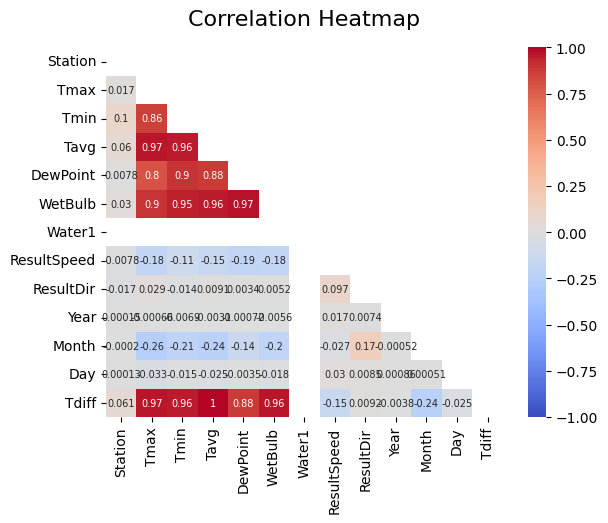

In [62]:
inspect_col(df_weather, 'WetBulb')

In [63]:
#impute missing values with linear regression based on dewpoint because of the highest correlation
wetbulb_ii = IterativeImputer(estimator = LinearRegression())
df_weather['WetBulb'] = pd.DataFrame(wetbulb_ii.fit_transform(df_weather[['DewPoint', 'WetBulb']]))[1]

### Heat

In [64]:
df_weather[['Tavg', 'DewPoint', 'Heat']].dropna().astype(float).groupby(df_weather['Month']).mean()

,Tavg,DewPoint,Heat
Month,,,
5,61.647059,46.342799,5.772819
6,71.295833,56.927083,0.731250
7,75.674089,60.763158,0.072874
8,74.307692,61.036437,0.074899
9,66.202929,53.497908,2.437238
10,54.382591,42.317814,11.251012


/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))


Number of missing in column: 3
Percentage of missing in column: 0.006048387096774193


/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":7}, cmap='coolwarm')


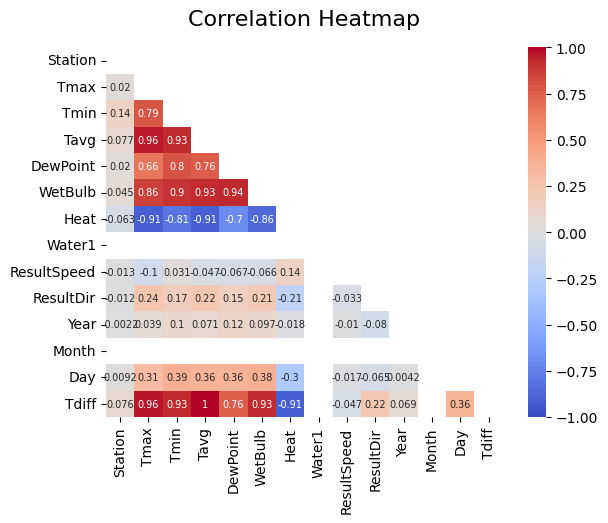

In [65]:
# More heat are used based on months. Hence, we observe the correlation based on month
inspect_col(df_weather[df_weather['Month']==5], 'Heat')

In [66]:
heat_lr = LinearRegression()
heat_df = df_weather[['Year', 'Month', 'Day', 'Tavg', 'Heat']].dropna()
heat_lr.fit(heat_df[['Year', 'Month', 'Day', 'Tavg']], heat_df['Heat'])
heat_lr.score(heat_df[['Year', 'Month', 'Day', 'Tavg']], heat_df['Heat'])

0.7640182285309189

In [67]:
heat_ii = IterativeImputer(estimator = LinearRegression())
df_weather['Heat'] = pd.DataFrame(heat_ii.fit_transform(df_weather[['Year', 'Month', 'Day', 'Tavg', 'Heat']]))[1]

### Cool

In [68]:
df_weather[['Tavg', 'DewPoint', 'Cool']].dropna().astype(float).groupby(df_weather['Month']).mean()

,Tavg,DewPoint,Cool
Month,,,
5,61.647059,46.342799,2.419878
6,71.295833,56.927083,7.027083
7,75.674089,60.763158,10.746964
8,74.307692,61.036437,9.382591
9,66.202929,53.497908,3.640167
10,54.382591,42.317814,0.633603


Number of missing in column: 3
Percentage of missing in column: 0.006048387096774193


/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))
/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":7}, cmap='coolwarm')


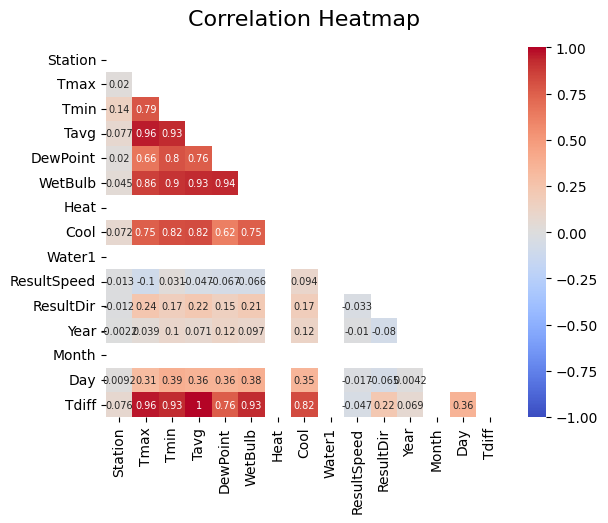

In [69]:
#More heat are used based on months. Hence, we observe the correlation based on month
inspect_col(df_weather[df_weather['Month']==5], 'Cool')

In [70]:
cool_lr = LinearRegression()
cool_df = df_weather[['Year', 'Month', 'Day', 'Tavg', 'Cool']].dropna()
cool_lr.fit(cool_df[['Year', 'Month', 'Day', 'Tavg']], cool_df['Cool'])
cool_lr.score(cool_df[['Year', 'Month', 'Day', 'Tavg']], cool_df['Cool'])

0.775613788830453

In [71]:
cool_ii = IterativeImputer(estimator = LinearRegression())
df_weather['Cool'] = pd.DataFrame(cool_ii.fit_transform(df_weather[['Year', 'Month', 'Day', 'Tavg', 'Cool']]))[1]

### Sunrise

Number of missing in column: 1472
Percentage of missing in column: 0.5


/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))
/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":7}, cmap='coolwarm')


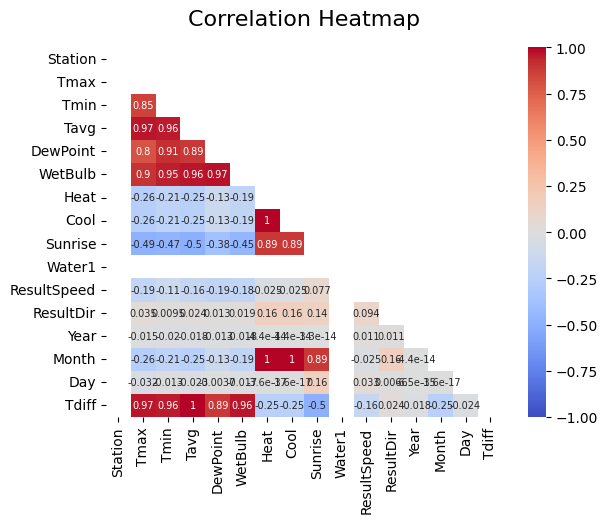

In [72]:
inspect_col(df_weather, 'Sunrise')

In [73]:
df_weather[['Station', 'Sunrise']][df_weather['Sunrise'].isnull()]['Station'].value_counts()

2    1472
Name: Station, dtype: int64

In [74]:
df_weather[['Station', 'Date', 'Sunrise']]

,Station,Date,Sunrise
0,1,2007-05-01,0448
1,2,2007-05-01,NaN
2,1,2007-05-02,0447
3,2,2007-05-02,NaN
4,1,2007-05-03,0446
...,...,...,...
2939,2,2014-10-29,NaN
2940,1,2014-10-30,0622
2941,2,2014-10-30,NaN
2942,1,2014-10-31,0623


Based on the above, we confirm that all the nan value is from station 2. Hence, if there are from the same date, we will use the same sunrise timing

In [75]:
for row in range(len(df_weather)):
    if type(df_weather.loc[row,'Sunrise']) != str:
        if df_weather.loc[row,'Date'] == df_weather.loc[row-1,'Date']:
            df_weather.loc[row,'Sunrise'] = df_weather.loc[row-1,'Sunrise']

In [76]:
# convert column to datetime after filling up
df_weather['Sunrise'] = pd.to_datetime(df_weather['Sunrise'], format='%I%M')

### Sunset

Number of missing in column: 1472
Percentage of missing in column: 0.5


/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))
/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":7}, cmap='coolwarm')


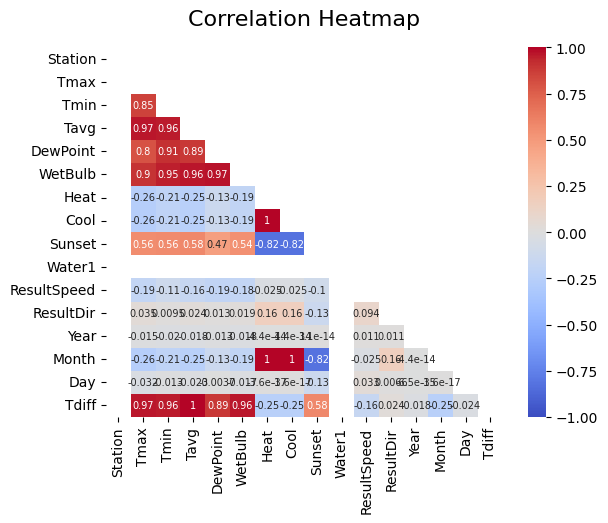

In [77]:
inspect_col(df_weather, 'Sunset')

In [78]:
df_weather[['Station', 'Sunset']][df_weather['Sunset'].isnull()]['Station'].value_counts()

2    1472
Name: Station, dtype: int64

In [79]:
for row in range(len(df_weather)):
    if type(df_weather.loc[row,'Sunset']) != str:
        if df_weather.loc[row,'Date'] == df_weather.loc[row-1,'Date']:
            df_weather.loc[row,'Sunset'] = df_weather.loc[row-1,'Sunset']

In [80]:
df_weather[['Station', 'Date', 'Sunset']]

,Station,Date,Sunset
0,1,2007-05-01,1849
1,2,2007-05-01,1849
2,1,2007-05-02,1850
3,2,2007-05-02,1850
4,1,2007-05-03,1851
...,...,...,...
2939,2,2014-10-29,1650
2940,1,2014-10-30,1649
2941,2,2014-10-30,1649
2942,1,2014-10-31,1647


In [81]:
df_weather['Sunset'][20]

'1860'

In [82]:
# Sunset data has a weird data that has 60 minutes. we will need to remove this and add it back to the hour mark
def clean_time(x):
    hour = int(x[:2])
    minute = int(x[2:])
    if minute == 60:
        hour += 1
        minute = '00'
    return str(hour)+str(minute)

In [83]:
df_weather['Sunset'] = df_weather['Sunset'].apply(clean_time)

In [84]:
# Convert column to datetime after filling up
df_weather['Sunset'] = pd.to_datetime(df_weather['Sunset'], format='%H%M')

## Sunset Hours 

Given that the missing values are only in the weather records for Stn2, we impute the same values from Stn 1 to Stn 2 on the same day.

In [85]:
df_weather['SunMins'] = df_weather['Sunset'] - df_weather['Sunrise']

In [86]:
# Converting the difference in Sunrise and Sunset to Number of minutes 
for i in range(len(df_weather)):
    df_weather['SunMins'][i] = df_weather['SunMins'][i].total_seconds()/60
    i = +1

### Depth

Number of missing in column: 1472
Percentage of missing in column: 0.5


/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))
/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":7}, cmap='coolwarm')


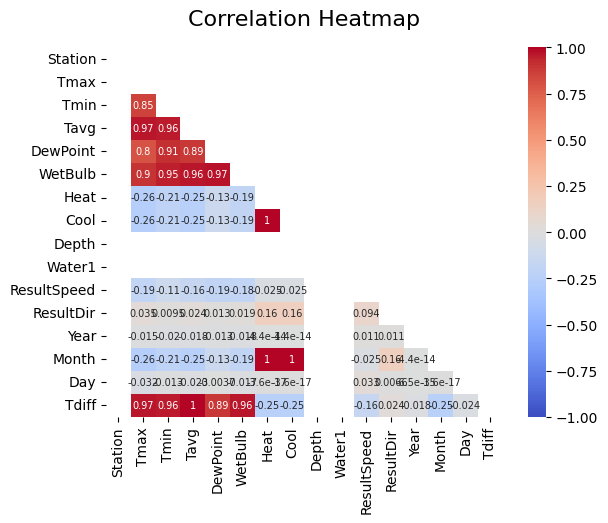

In [87]:
inspect_col(df_weather,'Depth')

We do not impute empty rows as the number of missing rows is 50% of dataset. Hence it's too big a percentage for us to infer. We will evaluate if its important in predicting mosquitos later

### Water1

In [88]:
df_weather['Water1']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2939   NaN
2940   NaN
2941   NaN
2942   NaN
2943   NaN
Name: Water1, Length: 2944, dtype: float64

All the water1 column is empty, we will have to drop this later

### SnowFall

In [89]:
df_weather['SnowFall'].isnull().sum()/len(df_weather)

0.5

We do not impute empty rows as the number of missing rows is 50% of dataset. Hence it's too big a percentage for us to infer. We will evaluate if its important in predicting mosquitos later

### PrecipTotal

In [90]:
df_weather['PrecipTotal'].value_counts()

0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
2.68       1
2.24       1
1.90       1
1.07       1
1.18       1
Name: PrecipTotal, Length: 167, dtype: int64

In [91]:
df_weather['PrecipTotal'][df_weather['PrecipTotal']!='  T'].astype(float).value_counts()

0.00    1577
0.01     127
0.02      63
0.03      46
0.04      36
        ... 
3.64       1
4.73       1
1.60       1
2.24       1
1.18       1
Name: PrecipTotal, Length: 166, dtype: int64

As T refers to Trace, we will assume T values to be the minimum value more than 0

For null values, we will assume mean value as there's only 2 missing

In [92]:
df_weather['PrecipTotal'].replace('  T', 0.01 ,inplace = True)

In [93]:
preciptotal_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_weather['PrecipTotal'] = preciptotal_imp.fit_transform(df_weather[['PrecipTotal']])

### StnPressure

Number of missing in column: 4
Percentage of missing in column: 0.001358695652173913


/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))
/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":7}, cmap='coolwarm')


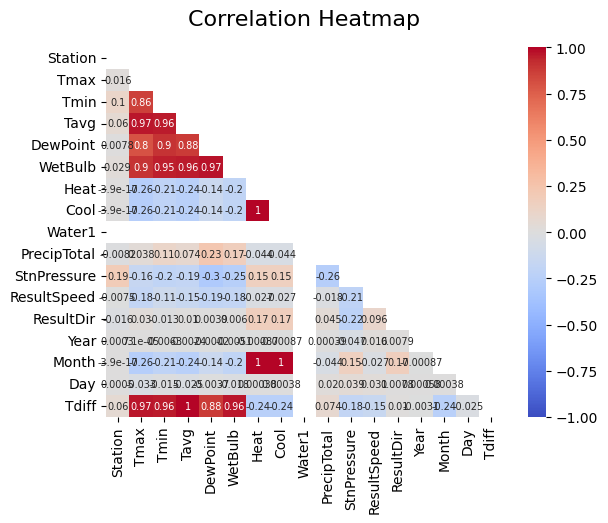

In [94]:
inspect_col(df_weather, 'StnPressure')

Since there's only 4 missing with low correlation with other features, we will impute using mean

In [95]:
stnpressure_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_weather['StnPressure'] = stnpressure_imp.fit_transform(df_weather[['StnPressure']])

### SeaLevel

Number of missing in column: 9
Percentage of missing in column: 0.0030570652173913045


/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))
/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":7}, cmap='coolwarm')


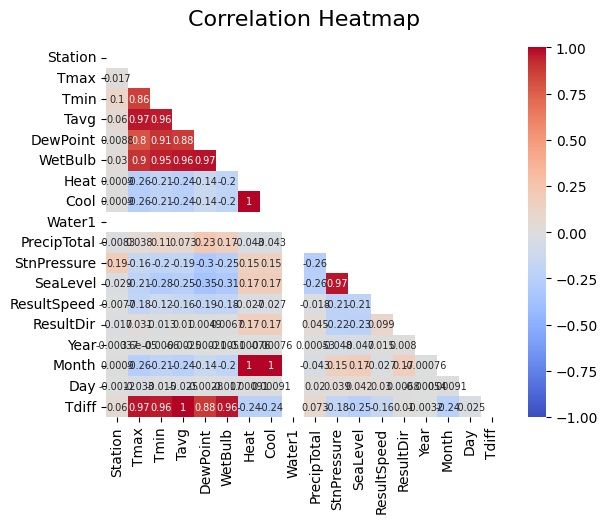

In [96]:
inspect_col(df_weather, 'SeaLevel')

In [97]:
#impute missing values with linear regression based on StnPressure because of the highest correlation
wetbulb_ii = IterativeImputer(estimator = LinearRegression())
df_weather['SeaLevel'] = pd.DataFrame(wetbulb_ii.fit_transform(df_weather[['StnPressure', 'SeaLevel']]))[1]

### AvgSpeed

Number of missing in column: 3
Percentage of missing in column: 0.0010190217391304348


/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))
/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/2473354868.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":7}, cmap='coolwarm')


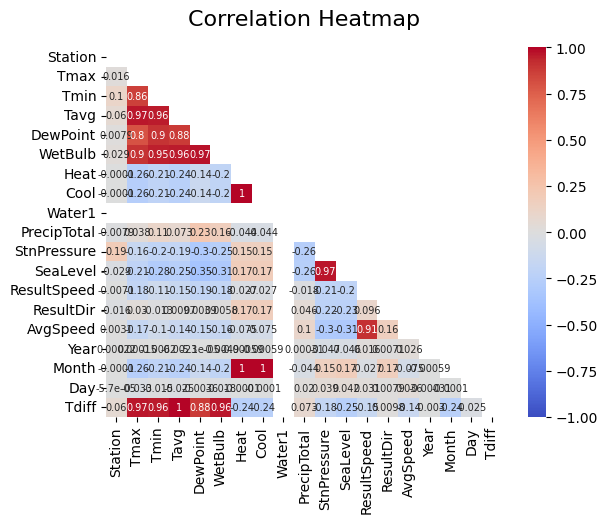

In [98]:
inspect_col(df_weather, 'AvgSpeed')

In [99]:
#impute missing values with linear regression based on ResultSpeed because of the highest correlation
wetbulb_ii = IterativeImputer(estimator = LinearRegression())
df_weather['AvgSpeed'] = pd.DataFrame(wetbulb_ii.fit_transform(df_weather[['ResultSpeed', 'AvgSpeed']]))[1]

In [100]:
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,Day,Tdiff,SunMins
0,1,2007-05-01,83,50,67,14,51,56.0,5.0,5.0,...,29.10,29.82,1.7,27,9.2,2007,5,1,66.5,841.0
1,2,2007-05-01,84,52,68,NaN,51,57.0,5.0,5.0,...,29.18,29.82,2.7,25,9.6,2007,5,1,68.0,841.0
2,1,2007-05-02,59,42,51,-3,42,47.0,5.0,5.0,...,29.38,30.09,13.0,4,13.4,2007,5,2,50.5,843.0
3,2,2007-05-02,60,43,52,NaN,42,47.0,5.0,5.0,...,29.44,30.08,13.3,2,13.4,2007,5,2,51.5,843.0
4,1,2007-05-03,66,46,56,2,40,48.0,5.0,5.0,...,29.39,30.12,11.7,7,11.9,2007,5,3,56.0,845.0


We dropped these columns as there are than 50% missing data.

In [101]:
# Drop Depart, Depth, Water1, Snowfall 

df_weather.drop(['Depart', 'Depth', 'Water1', 'SnowFall'], axis=1, inplace=True)

## Merge train and weather datasets for subsequent analyses 

In [102]:
# Merge df_train and df_weather 
df_train_combined = pd.merge(df_train, df_weather, on=['Date','Station'])

In [103]:
# Drop duplicated year, month and day columns after merging 
df_train_combined.drop(['Year_y', 'Month_y'], axis=1, inplace=True)

In [104]:
# Remove column suffix added during merging
df_train_combined.columns = df_train_combined.columns.str.replace('_x', '')

In [105]:
# Check for null values
df_train_combined.isnull().sum()

Date            0
Week            0
Month           0
Year            0
Species         0
Trap            0
Latitude        0
Longitude       0
NumMosquitos    0
WnvPresent      0
species_no      0
Station         0
Tmax            0
Tmin            0
Tavg            0
DewPoint        0
WetBulb         0
Heat            0
Cool            0
Sunrise         0
Sunset          0
CodeSum         0
PrecipTotal     0
StnPressure     0
SeaLevel        0
ResultSpeed     0
ResultDir       0
AvgSpeed        0
Day             0
Tdiff           0
SunMins         0
dtype: int64

In [106]:
# Examine data
df_train_combined.head()

,Date,Week,Month,Year,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,...,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Day,Tdiff,SunMins
0,2007-05-29,22,5,2007,CULEX PIPIENS,T096,41.731922,-87.677512,1,0,...,BR HZ,0.0,29.44,30.09,5.8,16,7.4,29,76.5,896.0
1,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0,...,BR HZ,0.0,29.44,30.09,5.8,16,7.4,29,76.5,896.0
2,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0,...,BR HZ,0.0,29.44,30.09,5.8,16,7.4,29,76.5,896.0
3,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T054,41.921965,-87.632085,2,0,...,BR HZ,0.0,29.44,30.09,5.8,16,7.4,29,76.5,896.0
4,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,1,0,...,BR HZ,0.0,29.44,30.09,5.8,16,7.4,29,76.5,896.0


In [107]:
df_train_combined = df_train_combined.reset_index()
df_train_combined = df_train_combined.rename(columns={"index":"New_ID"})
df_train_combined['New_ID'] = df_train_combined.index + 1

## Explore location of traps and mosquitoes

In [108]:
# Create a dataframe for trap coordinates
traps_coord = df_train_combined[['Trap','Latitude','Longitude']]
traps_coord.drop_duplicates('Trap', inplace=True)

In [109]:
# Group data by traps and their number of mosquitos
traps_mos = df_train_combined.groupby(['Trap']).NumMosquitos.sum()
traps_mos = traps_mos.sort_values(ascending=False)

In [110]:
# Merge both 
traps = pd.merge(traps_mos,traps_coord, how='inner', on=['Trap'])
traps

,Trap,NumMosquitos,Latitude,Longitude
0,T115,21668,41.673408,-87.599862
1,T900,15386,41.974689,-87.890615
2,T138,9936,41.726465,-87.585413
3,T002,3710,41.954690,-87.800991
4,T128,3315,41.704572,-87.565666
...,...,...,...,...
131,T072,19,41.747850,-87.702716
132,T237,18,41.738903,-87.695443
133,T078,17,41.775051,-87.655356
134,T149,15,41.994469,-87.667736


In [111]:
traps.sort_values('Trap').head(15)

,Trap,NumMosquitos,Latitude,Longitude
129,T001,25,41.953705,-87.733974
3,T002,3710,41.954690,-87.800991
23,T003,1346,41.964242,-87.757639
113,T004,59,41.962728,-87.748367
120,T005,50,41.942114,-87.776385
99,T006,107,41.990284,-87.797127
103,T007,77,41.994991,-87.769279
7,T008,2668,42.008314,-87.777921
14,T009,1940,41.981964,-87.812827
25,T011,1311,41.944869,-87.832763


In [112]:
# Find satelite traps
for trap in traps['Trap']:
    if len(trap)>4:
        print(trap)

T054C
T094B


In [113]:
# Drop them
traps = traps.loc[traps['Trap'] != 'T054C']
traps = traps.loc[traps['Trap'] != 'T094B']

In [114]:
traps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 135
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Trap          134 non-null    object 
 1   NumMosquitos  134 non-null    int64  
 2   Latitude      134 non-null    float64
 3   Longitude     134 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 5.2+ KB


In [115]:
# Find and replace trap 005 to 234
traps.loc[traps['Trap']=='T005']
traps.replace('T005','T234', inplace = True)

In [116]:
# Load map data
mapdata = np.loadtxt("./assets/mapdata_copyright_openstreetmap_contributors.txt/mapdata_copyright_openstreetmap_contributors.txt")

Text(0.5, 1.0, 'Locations of traps scaled to number of mosquitos')

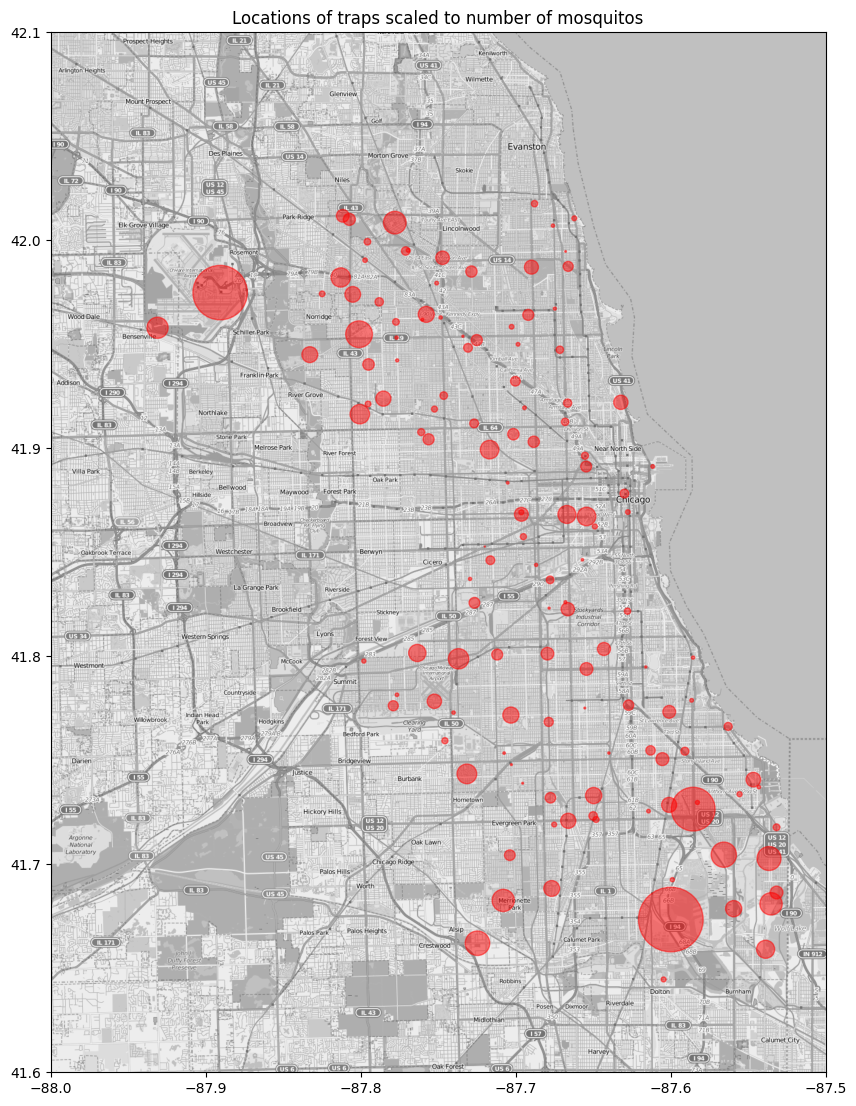

In [117]:
# Plot trap locations on map
plt.figure(figsize=(10,14))

lon_lat_box= (-88, -87.5, 41.6, 42.1)
asp = mapdata.shape[0] * 1.0 / mapdata.shape[1]
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, aspect=asp)

addresses = traps.loc[traps["NumMosquitos"]>0]

addresses_plot = plt.scatter(addresses['Longitude'], addresses['Latitude'], c="red", marker='o', s=traps['NumMosquitos']*0.1, alpha=0.5)

plt.title("Locations of traps scaled to number of mosquitos", fontsize=12)



### Spread of WnvPresent across different species of mosquitoes

In [118]:
mosq_count = df_train[['Date','Species','NumMosquitos','WnvPresent']].groupby(['Date','Species']).sum().reset_index()
mosq_count

,Date,Species,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS,1,0
1,2007-05-29,CULEX PIPIENS/RESTUANS,10,0
2,2007-05-29,CULEX RESTUANS,29,0
3,2007-06-05,CULEX PIPIENS,6,0
4,2007-06-05,CULEX PIPIENS/RESTUANS,28,0
...,...,...,...,...
373,2013-09-19,CULEX PIPIENS/RESTUANS,435,5
374,2013-09-19,CULEX RESTUANS,66,0
375,2013-09-26,CULEX PIPIENS,171,1
376,2013-09-26,CULEX PIPIENS/RESTUANS,309,3


In [119]:
mosq_count['WnvPresent'] = mosq_count['WnvPresent'].apply(lambda x: 1 if (x > 0) else 0)

In [120]:
mosq_count_wnv = mosq_count[mosq_count['WnvPresent']>0].pivot(index='Date', columns='Species', values = 'WnvPresent')
mosq_count_wnv

Species,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS
Date,,,
2007-07-18,NaN,1.0,NaN
2007-07-25,1.0,1.0,NaN
2007-08-01,1.0,1.0,NaN
2007-08-02,1.0,1.0,NaN
2007-08-07,1.0,1.0,1.0
2007-08-08,1.0,1.0,NaN
2007-08-09,1.0,NaN,NaN
2007-08-15,1.0,1.0,1.0
2007-08-16,1.0,1.0,NaN


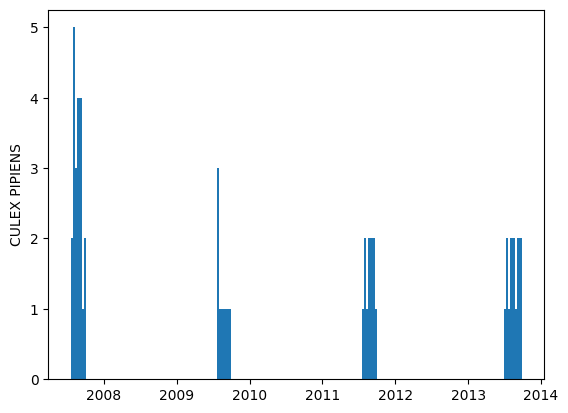

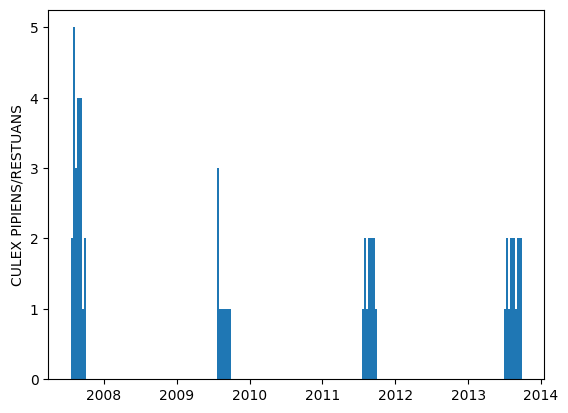

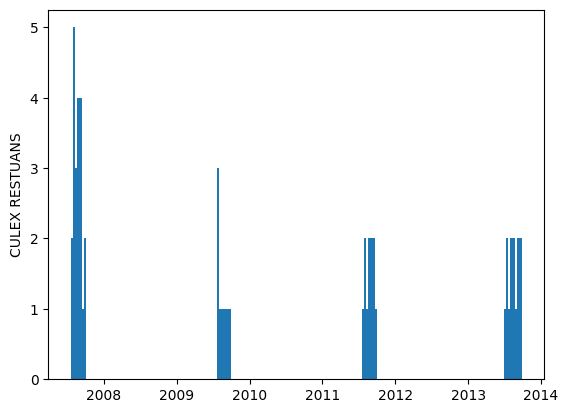

In [121]:
for species in mosq_count_wnv.columns:
    plt.hist(mosq_count_wnv[species].index,bins=200)
    plt.ylabel(species)
    plt.show()

The graph shows that there are only 3 types of mosquitoes species that has been detected to carry the virus. And that 2007 is an exceptional year where the number of WNV detected is higher than the rest of the years.

## Merge test and weather datasets for subsequent analyses 

In [122]:
# Merge df_train and df_weather 
df_test_combined = pd.merge(df_test, df_weather, on=['Date','Station'])

In [123]:
# Drop duplicated year, month and day columns after merging 
df_test_combined.drop(['Year_y', 'Month_y'], axis=1, inplace=True)

In [124]:
# Remove column suffix added during merging
df_test_combined.columns = df_test_combined.columns.str.replace('_x', '')

In [125]:
# Check for null values
df_test_combined.isnull().sum()

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
Week                      0
Month                     0
Year                      0
species_no                0
Station                   0
Tmax                      0
Tmin                      0
Tavg                      0
DewPoint                  0
WetBulb                   0
Heat                      0
Cool                      0
Sunrise                   0
Sunset                    0
CodeSum                   0
PrecipTotal               0
StnPressure               0
SeaLevel                  0
ResultSpeed               0
ResultDir                 0
AvgSpeed                  0
Day                       0
Tdiff                     0
SunMins                   0
dtype: int64

In [126]:
df_test_combined = df_test_combined.reset_index()
df_test_combined = df_test_combined.rename(columns={"index":"New_ID"})
df_test_combined['New_ID'] = df_test_combined.index + 1

## Feature engineering

### 1. CodeSum -> WetDry

- Given that there are multiple conditions, we have encoded them into two main conditions (wet and dry). Reason being is that mosquitoes love wet places and lay their eggs in puddles and anywhere else they can find standing water.

#### Train data

In [127]:
# Function to create features for each condition in the Codesum column

code_sums = []
wet_codes = ['RA', 'TS', 'DZ', 'BR', 'UP', 'SH']

for code in df_train_combined['CodeSum']:
    code.replace('+', ' ')
    code_row = code.split()
    check_wet = 0
    for val in code_row:
        val_2 = None
        if len(val) > 2:
            val_1 = val[:2]
            val_2 = val[2:]
        else:
            val_1 = val
        
        if val_1 in wet_codes or val_2 in wet_codes:
            check_wet = 1

    code_sums.append(check_wet)

In [128]:
# Convert Codesum to wetdry (0 = dry, 1 = wet) 
df_train_combined['CodeSum'] = code_sums
df_train_combined.rename(columns={'CodeSum': 'WetDry'}, inplace=True)

#### Test data

In [129]:
# Function to create features for each condition in the Codesum column
# df_test_combined = test and weather data

code_sums = []
wet_codes = ['RA', 'TS', 'DZ', 'BR', 'UP', 'SH']

for code in df_test_combined['CodeSum']:
    code.replace('+', ' ')
    code_row = code.split()
    check_wet = 0
    for val in code_row:
        val_2 = None
        if len(val) > 2:
            val_1 = val[:2]
            val_2 = val[2:]
        else:
            val_1 = val
        
        if val_1 in wet_codes or val_2 in wet_codes:
            check_wet = 1

    code_sums.append(check_wet)

In [130]:
# Convert Codesum to wetdry (0 = dry, 1 = wet) 
df_test_combined['CodeSum'] = code_sums
df_test_combined.rename(columns={'CodeSum': 'WetDry'}, inplace=True)

### 2. Humidity 
- We are considering humidity as well as relative humidity is important to mosquito activity. In general, high humidity conditions favor mosquito activity, while low humidity suppresses activity and may even cause mortality.

#### Train data

In [131]:
df_train_combined['Humidity'] = np.round(100-25/9*(df_train_combined['Tavg']-df_train_combined['DewPoint']),1)

In [132]:
df_train_combined['Humidity'].describe()

count    8475.000000
mean       62.656153
std        11.597413
min        33.300000
25%        52.800000
50%        61.100000
75%        72.200000
max        88.900000
Name: Humidity, dtype: float64

In [133]:
df_train_combined.loc[df_train_combined['Humidity']>100,'Humidity'] = 100

In [134]:
# Drop DewPoint
df_train_combined.drop(columns=['DewPoint'], inplace=True)

#### Test data

In [135]:
df_test_combined['Humidity'] = np.round(100-25/9*(df_test_combined['Tavg']-df_test_combined['DewPoint']),1)

In [136]:
df_test_combined['Humidity'].describe()

count    116293.000000
mean         59.019099
std          13.688713
min          11.100000
25%          50.000000
50%          61.100000
75%          69.400000
max          88.900000
Name: Humidity, dtype: float64

In [137]:
df_test_combined.loc[df_test_combined['Humidity']>100,'Humidity'] = 100

In [138]:
# Drop DewPoint
df_test_combined.drop(columns=['DewPoint'], inplace=True)

### 3. Create a new column to check if trap has been sprayed
- We would like to create a column to see if the trap located near the spray was sprayed within 30 days, which has been known to be effective.

In [139]:
# Create a function to check if the trap is located near spray

def check_near_spray(trap_loc, spray_loc):
    dist_tolerance = 300
    dist = geopy.distance.distance(trap_loc, spray_loc).feet
    return (dist <= dist_tolerance)

In [140]:
# Check unique spray dates
df_spray['Date'].unique()

array(['2011-08-29T00:00:00.000000000', '2011-09-07T00:00:00.000000000',
       '2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [141]:
# Create latitude and longitude list to pass into map for spray data
lat_long_spray = []
for date in df_spray['Date'].unique():
    temp = []
    for i, row in df_spray[df_spray['Date'] == date].iterrows():
        temp.append([row['Latitude'], row['Longitude']])
    lat_long_spray.append(temp)

In [142]:
# Create a dict for the 10 spray dates
# Each value will represent all the spray locations on that date
spray_dict = {}
for i, date in enumerate(df_spray['Date'].unique()):
    spray_dict[str(date).split('T')[0]] = lat_long_spray[i]

In [143]:
# Check unique traps
df_train_combined['Trap'].unique()

array(['T096', 'T048', 'T050', 'T054', 'T086', 'T129', 'T045', 'T046',
       'T049', 'T091', 'T094', 'T153', 'T159', 'T002', 'T015', 'T143',
       'T148', 'T007', 'T141', 'T142', 'T146', 'T149', 'T151', 'T218',
       'T009', 'T011', 'T016', 'T025', 'T028', 'T150', 'T220', 'T135',
       'T031', 'T090', 'T092', 'T158', 'T162', 'T019', 'T033', 'T089',
       'T145', 'T147', 'T152', 'T154', 'T088', 'T040', 'T047', 'T051',
       'T161', 'T034', 'T043', 'T085', 'T219', 'T001', 'T006', 'T012',
       'T003', 'T008', 'T037', 'T030', 'T084', 'T160', 'T013', 'T144',
       'T014', 'T018', 'T005', 'T017', 'T044', 'T095', 'T004', 'T060',
       'T061', 'T062', 'T065', 'T082', 'T035', 'T036', 'T039', 'T066',
       'T067', 'T069', 'T070', 'T071', 'T073', 'T079', 'T080', 'T081',
       'T083', 'T114', 'T155', 'T074', 'T076', 'T077', 'T075', 'T063',
       'T200', 'T206', 'T209', 'T212', 'T215', 'T115', 'T138', 'T107',
       'T128', 'T072', 'T027', 'T099', 'T100', 'T102', 'T103', 'T156',
      

In [144]:
df_train_combined.loc[df_train_combined['Trap'] == 'T002', ['Latitude', 'Longitude']].values[0]

array([ 41.95469 , -87.800991])

In [145]:
# Create a dict for all the trap locations
trap_locations = {}
for trap in df_train_combined['Trap'].unique():
    trap_locations[trap] = tuple(df_train_combined.loc[df_train_combined['Trap'] == trap, ['Latitude', 'Longitude']].values[0])

In [146]:
# Create a dict for all traps and spray date affecting it
trap_affected = {}
for trap_key, trap_value in trap_locations.items():
    dates = []
    for spray_key, spray_value in spray_dict.items():
        for spray_loc in spray_value:
            if check_near_spray(trap_value, spray_loc):
                dates.append(spray_key)
                break
    trap_affected[trap_key] = dates

In [147]:
# Create new column in train data
df_train_combined['trap_sprayed'] = 0

# Specified 30 days which spray will still be in effect
numdays = 30

# Infill value indicating if the trap is within spray zone
for trap, affected_dates in trap_affected.items():
    if len(affected_dates) > 0:
        for date in affected_dates:
            end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=numdays)
            df_train_combined.loc[(df_train_combined['Date'].between(datetime.strptime(date, '%Y-%m-%d'), end_date)) & (df_train_combined['Trap'] == trap), 'trap_sprayed'] = 1

In [148]:
df_train_combined.head()

,New_ID,Date,Week,Month,Year,Species,Trap,Latitude,Longitude,NumMosquitos,...,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Day,Tdiff,SunMins,Humidity,trap_sprayed
0,1,2007-05-29,22,5,2007,CULEX PIPIENS,T096,41.731922,-87.677512,1,...,29.44,30.09,5.8,16,7.4,29,76.5,896.0,50.0,0
1,2,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,...,29.44,30.09,5.8,16,7.4,29,76.5,896.0,50.0,0
2,3,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,...,29.44,30.09,5.8,16,7.4,29,76.5,896.0,50.0,0
3,4,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T054,41.921965,-87.632085,2,...,29.44,30.09,5.8,16,7.4,29,76.5,896.0,50.0,0
4,5,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,1,...,29.44,30.09,5.8,16,7.4,29,76.5,896.0,50.0,0


In [149]:
# list out traps that have been sprayed 
df_train_combined.loc[df_train_combined['trap_sprayed'] == 1]

,New_ID,Date,Week,Month,Year,Species,Trap,Latitude,Longitude,NumMosquitos,...,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Day,Tdiff,SunMins,Humidity,trap_sprayed
6094,6095,2011-09-12,37,9,2011,CULEX PIPIENS/RESTUANS,T223,41.973845,-87.805059,8,...,29.18,29.91,10.5,23,10.9,12,75.0,761.0,55.6,1
6105,6106,2011-09-12,37,9,2011,CULEX RESTUANS,T223,41.973845,-87.805059,2,...,29.18,29.91,10.5,23,10.9,12,75.0,761.0,55.6,1
6219,6220,2011-09-16,37,9,2011,CULEX PIPIENS/RESTUANS,T223,41.973845,-87.805059,9,...,29.59,30.33,1.4,8,3.3,16,52.0,748.0,66.7,1
6228,6229,2011-09-16,37,9,2011,CULEX RESTUANS,T223,41.973845,-87.805059,7,...,29.59,30.33,1.4,8,3.3,16,52.0,748.0,66.7,1
6319,6320,2011-09-23,38,9,2011,CULEX PIPIENS/RESTUANS,T009,41.992478,-87.862995,1,...,29.33,30.06,5.9,36,7.0,23,55.0,728.0,69.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8233,8234,2013-09-12,36,9,2013,CULEX PIPIENS,T230,41.904194,-87.756155,70,...,29.34,29.97,6.8,34,9.8,12,73.0,761.0,58.3,1
8269,8270,2013-09-12,36,9,2013,CULEX PIPIENS/RESTUANS,T230,41.904194,-87.756155,45,...,29.34,29.97,6.8,34,9.8,12,73.0,761.0,58.3,1
8293,8294,2013-09-19,37,9,2013,CULEX PIPIENS,T233,42.009876,-87.807277,21,...,29.14,29.87,8.3,16,10.6,19,76.5,739.0,75.0,1
8304,8305,2013-09-19,37,9,2013,CULEX PIPIENS/RESTUANS,T028,41.986921,-87.689778,14,...,29.14,29.87,8.3,16,10.6,19,76.5,739.0,75.0,1


### Test data

In [150]:
# Check unique traps
df_test_combined['Trap'].unique()

array(['T002', 'T007', 'T015', 'T143', 'T148', 'T009', 'T011', 'T016',
       'T025', 'T028', 'T141', 'T142', 'T146', 'T149', 'T150', 'T151',
       'T218', 'T220', 'T001', 'T003', 'T006', 'T008', 'T012', 'T037',
       'T013', 'T014', 'T018', 'T144', 'T005', 'T017', 'T004', 'T027',
       'T900', 'T903', 'T218A', 'T218B', 'T223', 'T228', 'T231', 'T002A',
       'T002B', 'T233', 'T234', 'T236', 'T045', 'T046', 'T048', 'T049',
       'T050', 'T054', 'T086', 'T091', 'T094', 'T096', 'T129', 'T153',
       'T159', 'T019', 'T031', 'T033', 'T089', 'T090', 'T092', 'T135',
       'T145', 'T147', 'T152', 'T154', 'T158', 'T162', 'T034', 'T040',
       'T043', 'T047', 'T051', 'T085', 'T088', 'T161', 'T219', 'T030',
       'T084', 'T160', 'T044', 'T095', 'T035', 'T036', 'T039', 'T060',
       'T061', 'T062', 'T065', 'T066', 'T067', 'T069', 'T070', 'T071',
       'T073', 'T074', 'T075', 'T076', 'T077', 'T079', 'T080', 'T081',
       'T082', 'T083', 'T114', 'T155', 'T063', 'T115', 'T138', 'T200',
  

In [151]:
df_test_combined.loc[df_test_combined['Trap'] == 'T002', ['Latitude', 'Longitude']].values[0]

array([ 41.95469 , -87.800991])

In [152]:
# Create a dict for all the trap locations
trap_locations = {}
for trap in df_test_combined['Trap'].unique():
    trap_locations[trap] = tuple(df_test_combined.loc[df_test_combined['Trap'] == trap, ['Latitude', 'Longitude']].values[0])

In [153]:
# Create a dict for all traps and spray date affecting it
trap_affected = {}
for trap_key, trap_value in trap_locations.items():
    dates = []
    for spray_key, spray_value in spray_dict.items():
        for spray_loc in spray_value:
            if check_near_spray(trap_value, spray_loc):
                dates.append(spray_key)
                break
    trap_affected[trap_key] = dates

In [154]:
# Create new column in test data
df_test_combined['trap_sprayed'] = 0

# Specified 30 days which spray will still be in effect
numdays = 30

# Infill value indicating if the trap is within spray zone
for trap, affected_dates in trap_affected.items():
    if len(affected_dates) > 0:
        for date in affected_dates:
            end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=numdays)
            df_test_combined.loc[(df_test_combined['Date'].between(datetime.strptime(date, '%Y-%m-%d'), end_date)) & (df_test_combined['Trap'] == trap), 'trap_sprayed'] = 1

In [155]:
# list out traps that have been sprayed 
df_test_combined.loc[df_test_combined['trap_sprayed'] == 1]

,New_ID,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,...,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Day,Tdiff,SunMins,Humidity,trap_sprayed


### 4. DaysSinceJun1 - number of days since jun 1
- This is for deeper analysis usage later on such as to calculate weightage of wnv, mosquito count based on days since jun 1
we assume May 29 to be same as June 1

In [156]:
# confirm the theory based on train data
df_train_combined['Month'][df_train_combined['WnvPresent']>0].value_counts()

8     303
9     110
7      41
10      2
6       1
Name: Month, dtype: int64

In [157]:
#calculate days from jun 1. Only valid for the same year
def days_from_jun1(date):
    if date.month >= 6 :
        mnth_dif = max(0, date.month - 6)
        day_dif = date.day-1
        return mnth_dif*31+day_dif
    return 0

In [158]:
df_train_combined['days_from_jun1'] = df_train_combined['Date'].apply(days_from_jun1)
df_test_combined['days_from_jun1'] = df_test_combined['Date'].apply(days_from_jun1)

In [159]:
df_train_combined['days_from_jun1'].sort_values()

0         0
2806      0
2807      0
2808      0
2809      0
       ... 
2756    132
2755    132
2773    132
2763    132
2774    132
Name: days_from_jun1, Length: 8475, dtype: int64

In [160]:
df_test_combined['days_from_jun1'].sort_values()

31699       1
31299       1
31298       1
31297       1
31296       1
         ... 
115484    125
115483    125
115482    125
115480    125
116292    125
Name: days_from_jun1, Length: 116293, dtype: int64

### 5. Approximate normal distribution of WnvPresent in a year
- This is to give more weight in the months and dates where historically, there's higher chance of a mosquito having WNV

#### By Species

In [161]:
df_train_combined['Species'].value_counts().index

Index(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX TERRITANS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'],
      dtype='object')

In [162]:
species = df_train_combined['Species'].value_counts().index

In [163]:
days_from_jun1_Wnv_species = {}
for specie in species:
    days_from_jun1_Wnv_species[specie] = [df_train_combined['days_from_jun1'][(df_train_combined['WnvPresent']>0) & (df_train_combined['Species']==specie)].values.mean(), df_train_combined['days_from_jun1'][(df_train_combined['WnvPresent']>0) & (df_train_combined['Species']==specie)].values.std()]

/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/1791522944.py:3: RuntimeWarning: Mean of empty slice.
  days_from_jun1_Wnv_species[specie] = [df_train_combined['days_from_jun1'][(df_train_combined['WnvPresent']>0) & (df_train_combined['Species']==specie)].values.mean(), df_train_combined['days_from_jun1'][(df_train_combined['WnvPresent']>0) & (df_train_combined['Species']==specie)].values.std()]
/Users/richelle-joychia/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/richelle-joychia/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/richelle-joychia/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.tr

In [164]:
days_from_jun1_Wnv_species

{'CULEX PIPIENS/RESTUANS': [81.48444444444445, 17.366915616328978],
 'CULEX RESTUANS': [68.72916666666667, 18.25027349490656],
 'CULEX PIPIENS': [84.66847826086956, 13.365021099446787],
 'CULEX TERRITANS': [nan, nan],
 'CULEX SALINARIUS': [nan, nan],
 'CULEX TARSALIS': [nan, nan],
 'CULEX ERRATICUS': [nan, nan]}

In [165]:
def add_pdf(specie, day):
    mean, std = days_from_jun1_Wnv_species[specie]
    return scipy.stats.norm.pdf((day-mean)/std) 

In [166]:
df_train_combined['norm'] = 0
for row in range(len(df_train_combined)):
    df_train_combined['norm'][row] = add_pdf(df_train_combined['Species'][row], df_train_combined['days_from_jun1'][row])

In [167]:
df_test_combined['norm'] = 0
for row in range(len(df_test_combined)):
    if df_test_combined['Species'][row] == 'UNSPECIFIED CULEX':
        df_test_combined['norm'][row] = 0
    else:
        df_test_combined['norm'][row] = add_pdf(df_test_combined['Species'][row], df_test_combined['days_from_jun1'][row])

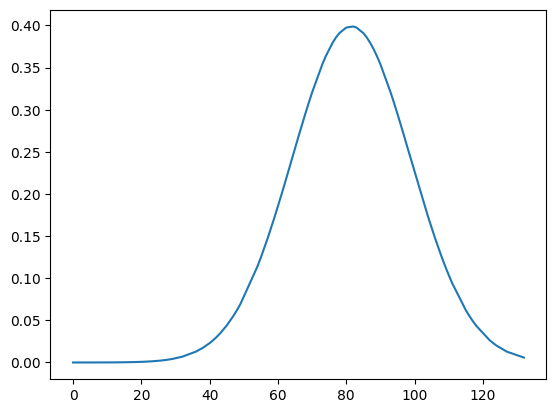

In [169]:
#to confirm our final norm column is a normal distribution shape
plt.plot(df_train_combined[['days_from_jun1','norm']][df_train_combined['Species']=='CULEX PIPIENS/RESTUANS'].groupby('days_from_jun1').mean())

#### Overall regardless of species

In [170]:
days_from_jun1_Wnv = df_train_combined['days_from_jun1'][df_train_combined['WnvPresent']>0].values

(array([  1.,   7.,  24.,  46., 108., 122.,  53.,  69.,  20.,   7.]),
 array([ 27.,  37.,  47.,  57.,  67.,  77.,  87.,  97., 107., 117., 127.]),
 <BarContainer object of 10 artists>)

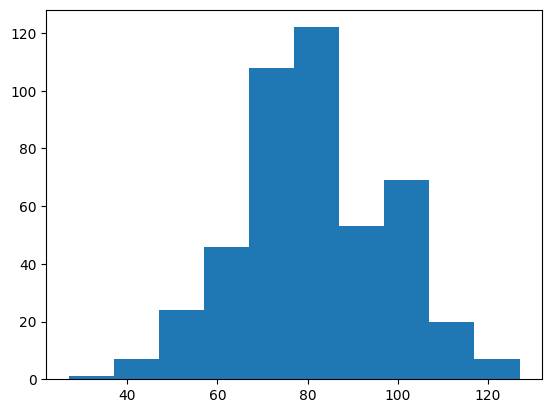

In [171]:
plt.hist(days_from_jun1_Wnv)

In [172]:
df_train_combined['overall_norm'] = [scipy.stats.norm.pdf((d-days_from_jun1_Wnv.mean())/days_from_jun1_Wnv.std()) for d in [df_train_combined['days_from_jun1']]][0]

In [173]:
df_train_combined[['days_from_jun1','overall_norm']]

,days_from_jun1,overall_norm
0,0,0.000002
1,0,0.000002
2,0,0.000002
3,0,0.000002
4,0,0.000002
...,...,...
8470,118,0.035536
8471,118,0.035536
8472,118,0.035536
8473,118,0.035536


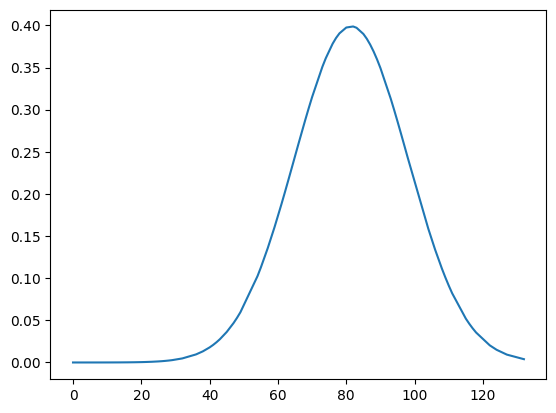

In [174]:
#to confirm our final norm column is a normal distribution shape
plt.plot(df_train_combined[['days_from_jun1','overall_norm']].groupby('days_from_jun1').mean())

We also did a check to ensure that all mosquitos having WNV roughly follow a normal distribution.

In [175]:
df_test_combined['overall_norm'] = [scipy.stats.norm.pdf((d-days_from_jun1_Wnv.mean())/days_from_jun1_Wnv.std()) for d in [df_test_combined['days_from_jun1']]][0]

### 6. Generate trap distance matrix to replace values
- There are some traps with missing data and we have created a matrix to replace the values with nearby ones.

In [176]:
# based on our map, we define a dict of land traps that are nearby satelite traps to replace them:
test_replacement_dict={'T002A':'T014',
                  'T002B':'T002',
                  'T054C':'T054',
                  'T094B':'T094',
                  'T065A':'T065',
                  'T090B':'T090',
                  'T090A':'T086',
                  'T090C':'T086',
                  'T128A':'T099',
                  'T200A':'T099',
                  'T200B':'T221',
                  'T218A':'T001',
                  'T218B':'T001',
                  'T218C':'T222'}


In [177]:
df_test_combined=df_test_combined.replace(test_replacement_dict)

In [178]:
# based on our map, we define a dict of land traps that are nearby satelite traps to replace them:
train_replacement_dict={'T094B':'T094',
                        'T054C':'T054'}

In [179]:
df_train_combined=df_train_combined.replace(train_replacement_dict)

In [180]:
# find and replace trap 005 to 234 (train)
df_train_combined.loc[df_train_combined['Trap']=='T005']
df_train_combined.replace('T005','T234', inplace = True)


In [181]:
# find and replace trap 005 to 234 (train)
df_test_combined.loc[df_test_combined['Trap']=='T005']
df_test_combined.replace('T005','T234', inplace = True)

In [182]:
# create a dataframe of trap names and coordinates
trap_locations = traps[['Trap','Latitude','Longitude']]

# convert lat/long values from degree to radian
trap_locations['Latitude'] = np.radians(trap_locations['Latitude'])
trap_locations['Longitude'] = np.radians(trap_locations['Longitude'])


In [183]:
# generate distance object
dist = DistanceMetric.get_metric('haversine')

# create an array of coordinates
trap_distance_array=trap_locations[['Latitude','Longitude']].to_numpy()

# fit distance object to array * 6373 to get distance in km
distance =dist.pairwise(trap_distance_array)*6373

/Users/richelle-joychia/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


In [184]:
trap_distance_matrix = pd.DataFrame(distance, columns = traps['Trap'], index=traps['Trap'])
trap_distance_matrix

Trap,T115,T900,T138,T002,T128,T135,T103,T008,T212,T158,...,T051,T229,T076,T001,T060,T072,T237,T078,T149,T040
Trap,,,,,,,,,,,,,,,,,,,,,
T115,0.000000,41.277339,6.022282,35.452596,4.481476,10.442352,6.191580,40.067287,5.437186,9.039364,...,19.802922,9.497004,13.566501,33.100467,17.876097,11.895399,10.773514,12.208342,36.151857,22.285845
T900,41.277339,0.000000,37.439837,7.739010,40.346113,37.402321,42.145552,10.039214,43.991989,35.843822,...,24.046155,32.208555,30.292329,13.163781,24.355350,29.646265,30.810161,29.542243,18.558484,19.594801
T138,6.022282,37.439837,0.000000,31.041085,2.935667,13.603255,4.844473,35.172297,6.559260,11.287393,...,14.587067,5.419564,8.011070,28.114510,13.225722,10.022552,9.237362,7.930494,30.580168,17.926960
T002,35.452596,7.739010,31.041085,0.000000,33.976254,33.164537,35.581265,6.262183,37.584169,31.232740,...,16.961026,26.067957,23.476318,5.544685,17.816516,24.405115,25.545610,23.340554,11.874376,13.186935
T128,4.481476,40.346113,2.935667,33.976254,0.000000,14.026244,2.431008,38.087397,3.648274,12.069869,...,17.485599,8.209675,10.868252,31.024044,16.160359,12.353630,11.430830,10.810588,33.335764,20.854966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T072,11.895399,29.646265,10.022552,24.405115,12.353630,9.719063,14.683348,29.633292,15.774637,7.272303,...,11.588763,5.256072,8.888827,23.043215,8.606220,0.000000,1.163919,4.959266,27.583970,11.743738
T237,10.773514,30.810161,9.237362,25.545610,11.430830,8.888713,13.795903,30.735286,14.785421,6.349836,...,12.363873,4.890261,9.059803,24.104757,9.467728,1.163919,0.000000,5.218237,28.519059,12.813626
T078,12.208342,29.542243,7.930494,23.340554,10.810588,13.825358,12.729515,27.859918,14.458781,11.173802,...,7.924175,2.730522,3.934037,20.911569,5.671521,4.959266,5.218237,0.000000,24.427350,10.154943


In [185]:
col=[]
for i in trap_distance_matrix.columns:
    col.append(i)

In [186]:
for c in col:
    trap_distance_matrix[c] = trap_distance_matrix[c].apply(lambda x : 1/x if 0 < x < 3 else 0)
    

In [187]:
trap_distance_matrix.to_csv('./assets/trap_distance_matrix.csv')

In [188]:
def cal_neigh_mosq(df, df_matrix):
    df['neigh_mosq_sum'] = 0
    for row in range(len(df)):
        trap_focus = df.iloc[row]['Trap']
        date_focus = df.iloc[row]['Date']
        species_focus = df.iloc[row]['Species']

        related_traps = df_matrix[trap_focus][df_matrix[trap_focus]>0]

        neigh_mosq_sum = 0
        for trap, weight in related_traps.iteritems():
            if len(df['NumMosquitos'][(df['Trap']==trap) & (df['Date']==date_focus) & (df['Species']==species_focus)].values) == 0:
                pass
            else:
                neigh_mosq_sum += (df['NumMosquitos'][(df['Trap']==trap) & (df['Date']==date_focus) & (df['Species']==species_focus)].values[0])*weight

        df['neigh_mosq_sum'][row] = neigh_mosq_sum

In [189]:
cal_neigh_mosq(df_train_combined, trap_distance_matrix)

/var/folders/_h/y5c9n2xs6qj32b1f_mr0b0ch0000gn/T/ipykernel_6904/977110176.py:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for trap, weight in related_traps.iteritems():


### 7. Rolling averages of weather information
- This is based on the knowledge that mosquitos breeding period is on average 8 to 10 days. [Source](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjt5YDe4_X6AhX49XMBHW2CDWgQFnoECAwQAw&url=https%3A%2F%2Fwww.cdc.gov%2Fdengue%2Fresources%2Ffactsheets%2Fmosquitolifecyclefinal.pdf&usg=AOvVaw2rbdP-eiZURqyRGrOEVf_6). Hence we take the average of 9 to calculate how conducive the weather is for the mosquito to breed and grow into adult

In [190]:
df_train_combined['multi_Tavg'] = df_train_combined['Tavg'].rolling(9).mean()
df_train_combined['multi_WetBulb'] = df_train_combined['WetBulb'].rolling(9).mean()
df_train_combined['multi_PrecipTotal'] = df_train_combined['PrecipTotal'].rolling(9).mean()
df_train_combined['multi_AvgSpeed'] = df_train_combined['AvgSpeed'].rolling(9).mean()
df_train_combined['multi_Humidity'] = df_train_combined['Humidity'].rolling(9).mean()
df_train_combined['multi_SunMins'] = df_train_combined['SunMins'].rolling(9).mean()

In [191]:
df_test_combined['multi_Tavg'] = df_test_combined['Tavg'].rolling(9).mean()
df_test_combined['multi_WetBulb'] = df_test_combined['WetBulb'].rolling(9).mean()
df_test_combined['multi_PrecipTotal'] = df_test_combined['PrecipTotal'].rolling(9).mean()
df_test_combined['multi_AvgSpeed'] = df_test_combined['AvgSpeed'].rolling(9).mean()
df_test_combined['multi_Humidity'] = df_test_combined['Humidity'].rolling(9).mean()
df_test_combined['multi_SunMins'] = df_test_combined['SunMins'].rolling(9).mean()

## Preparing Test Data for modeling in the next notebook.

In [192]:
df_test_combined['days_from_jun1'] = df_test_combined['Date'].apply(days_from_jun1)

In [193]:
df_test_combined['Date'] = pd.to_datetime(df_test_combined['Date'], format='%Y-%m-%d')
df_test_combined['Week'] = (df_test_combined['Date'].dt.strftime('%W')).astype(int)
df_test_combined['Month'] = (df_test_combined['Date'].dt.strftime('%m')).astype(int)
df_test_combined['Year'] = (df_test_combined['Date'].dt.strftime('%Y')).astype(int)

### Attempting to derive number of mosquitoes based on date for test data

In [194]:
df_train_2007_CULEX_PIPIENS_RESTUANS = df_train_combined[['days_from_jun1','NumMosquitos']][(df_train_combined['Year']==2007)&(df_train_combined['Species']=='CULEX PIPIENS/RESTUANS')]
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df_train_2007_CULEX_PIPIENS_RESTUANS[['days_from_jun1']])
lr = LinearRegression()
lr.fit(poly_features, df_train_2007_CULEX_PIPIENS_RESTUANS['NumMosquitos'])
lr.score(poly_features, df_train_2007_CULEX_PIPIENS_RESTUANS['NumMosquitos'])
y_pred = lr.predict(poly_features)

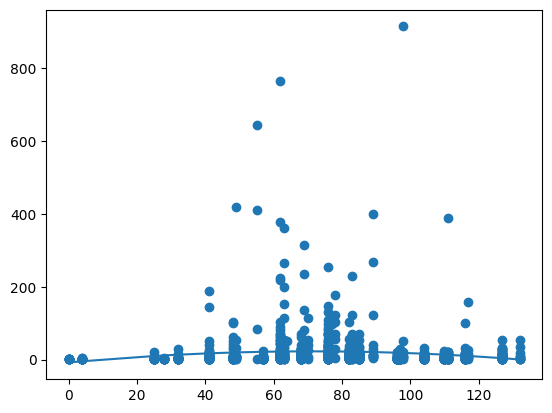

In [195]:
plt.scatter(df_train_2007_CULEX_PIPIENS_RESTUANS['days_from_jun1'], df_train_2007_CULEX_PIPIENS_RESTUANS['NumMosquitos'])
plt.plot(df_train_2007_CULEX_PIPIENS_RESTUANS['days_from_jun1'], y_pred)

From the above graph, we can see and tell that there are days where the mosquito count greatly deviate from the mean. This could be due to outbreak of the mosquito in that year. Since we do not know when outbreaks happen during the test years, we will not proceed further to attempt to estiamte the number of mosquitos. We will drop number of mosquitos as part of the x variables when classifying WnvPresent

## DF checks

In [196]:
#checking columns that are not in df_train_combined, but in df_test combined
list(set(df_test_combined.columns) - set(df_train_combined.columns.intersection(df_test_combined.columns)))

['Block',
 'AddressNumberAndStreet',
 'Address',
 'AddressAccuracy',
 'Street',
 'Id']

In [197]:
#we will drop these are these are not important
df_test_combined.drop(['Block', 'AddressNumberAndStreet', 'Street', 'AddressAccuracy', 'Address'], axis = 1, inplace = True)

In [198]:
#checking columns that are not in df_test_combined, but in df_train_combined
list(set(df_train_combined.columns) - set(df_test_combined.columns.intersection(df_train_combined.columns)))

['NumMosquitos', 'neigh_mosq_sum', 'WnvPresent']

In [199]:
df_train_combined.to_csv('./assets/df_train_combined.csv', index=False)
df_test_combined.to_csv('./assets/df_test_combined.csv', index=False)

## Let's move on to the two modeling notebooks.